In [1]:
# General imports
import os
import yaml
import pandas as pd
import numpy as np
from datetime import datetime
from pytz import utc

# Keras imports
import keras

# Sklearn imports
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

# Viz imports
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
sns.set_style('white')

# Custom imports
import keras_helpers
import load_model_config
import define_model

Using TensorFlow backend.


In [165]:
paths = []
timestamps = []
for path in os.listdir('.'):
    try:
        timestamp = datetime.strptime(path, "%Y-%m-%dT%H,%M,%S.%fZ").replace(tzinfo = utc)
    except ValueError:
        pass
    else:
        timestamps.append(timestamp)
        paths.append(path)
paths = [x[1] for x in sorted(zip(timestamps, paths), key = lambda x: x[0])]

In [166]:
# Load data and model
avail_metrics = {}
avail_metrics.update(vars(sklearn.metrics))
avail_metrics.update(vars(keras_helpers))

path = paths[-1]

config = load_model_config.Config(path)

np.random.seed(config.rand_seed)

# Define scaler
scalerX = joblib.load(path + "/scaler.pkl")

raw_df_train = pd.read_csv(path + "/raw_train.csv", index_col = 0)
X_df_train = pd.read_csv(path + "/X_train.csv", index_col = 0)
y_df_train = pd.read_csv(path + "/y_train.csv", index_col = 0)

raw_df_test = pd.read_csv(path + "/raw_test.csv", index_col = 0)
X_df_test = pd.read_csv(path + "/X_test.csv", index_col = 0)
y_df_test = pd.read_csv(path + "/y_test.csv", index_col = 0)

X_train = X_df_train.values
X_train_scaled = scalerX.transform(X_train)
y_train = y_df_train.values

X_test = X_df_test.values
X_test_scaled = scalerX.transform(X_test)
y_test = y_df_test.values

model = define_model.create_model(X_train.shape[1], y_train.shape[1], path = path)
model.load_weights(path + "/model.h5")

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

In [167]:
raw_df_train.columns

Index(['2FACE2VOLUMEMAX', '2FACE2VOLUMEMEAN', '2FACE2VOLUMEMIN',
       '2FACE2VOLUMESTDEV', '2FACEN1FACESMAX', '2FACEN1FACESMEAN',
       '2FACEN1FACESMIN', '2FACEN1FACESSTDEV', '2FACEN1POINTSMAX',
       '2FACEN1POINTSMEAN', '2FACEN1POINTSMIN', '2FACEN1POINTSSTDEV',
       '2FACEN2POINTSMAX', '2FACEN2POINTSMEAN', '2FACEN2POINTSMIN',
       '2FACEN2POINTSSTDEV', '2FACEN2VERTSMAX', '2FACEN2VERTSMEAN',
       '2FACEN2VERTSMIN', '2FACEN2VERTSSTDEV', '3FACE3VOLUMEMAX',
       '3FACE3VOLUMEMEAN', '3FACE3VOLUMEMIN', '3FACE3VOLUMESTDEV',
       '3FACEN1FACESMAX', '3FACEN1FACESMEAN', '3FACEN1FACESMIN',
       '3FACEN1FACESSTDEV', '3FACEN1POINTSMAX', '3FACEN1POINTSMEAN',
       '3FACEN1POINTSMIN', '3FACEN1POINTSSTDEV', '3FACEN2FACESMAX',
       '3FACEN2FACESMEAN', '3FACEN2FACESMIN', '3FACEN2FACESSTDEV',
       '3FACEN2POINTSMAX', '3FACEN2POINTSMEAN', '3FACEN2POINTSMIN',
       '3FACEN2POINTSSTDEV', '3FACEN3POINTSMAX', '3FACEN3POINTSMEAN',
       '3FACEN3POINTSMIN', '3FACEN3POINTSSTDEV', '3FACE

In [168]:
[config.loss] + config.metrics

['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error']

In [169]:
model.evaluate(X_train_scaled, y_train)

37449/37449 [==============================] - 1s 37us/step


[0.013465832451045037, 0.063527860361576885, 31.495900133919271]

In [170]:
model.evaluate(X_test_scaled, y_test)

29425/29425 [==============================] - 1s 37us/step


[0.013493252305429471, 0.063602858507845902, 31.86023911857767]

In [171]:
# Explained Variance Score (EVS)
evs = avail_metrics["explained_variance_score"]
evs_train = evs(y_train, y_train_pred)
evs_test = evs(y_test, y_test_pred)
evs_train, evs_test

(0.91293305524974144, 0.91344379780757523)

In [172]:
# Mean Absolute Error (MAE)
mae = avail_metrics["mean_absolute_error"]
mae_train = mae(y_train, y_train_pred)
mae_test = mae(y_test, y_test_pred)
mae_train, mae_test

(0.063527859539207324, 0.063602857823861797)

In [173]:
# Mean Absolute Percentage Error (MAPE)
mape = avail_metrics["mean_absolute_percentage_error"]
mape_train = mape(y_train, y_train_pred)
mape_test = mape(y_test, y_test_pred)
mape_train, mape_test

(31.495899875374576, 31.860238836508429)

In [174]:
# Mean Squared Error (MSE)
mse = avail_metrics["mean_squared_error"]
mse_train = mse(y_train, y_train_pred)
mse_test = mse(y_test, y_test_pred)
mse_train, mse_test

(0.0085078960880268298, 0.0085353159075809322)

In [175]:
# Mean Squared Logarithmic Error (MSLE)
msle = avail_metrics["mean_squared_log_error"]
msle_train = msle(y_train, y_train_pred)
msle_test = msle(y_test, y_test_pred)
msle_train, msle_test

(0.0039306433379989476, 0.0039415073620750769)

In [176]:
# Median Absolute Error (MAE)
medae = avail_metrics["median_absolute_error"]
medae_train = medae(y_train, y_train_pred)
medae_test = medae(y_test, y_test_pred)
medae_train, medae_test

(0.047598712974124519, 0.047744035720825195)

In [177]:
# R2 score
r2 = avail_metrics["r2_score"]
r2_train = r2(y_train, y_train_pred)
r2_test = r2(y_test, y_test_pred)
r2_train, r2_test

(0.91242913329613262, 0.9129899026958247)

In [178]:
raw_df = pd.concat([raw_df_train, raw_df_test], axis = 0)
X_df = pd.concat([X_df_train, X_df_test], axis = 0)
scaled_X_df = pd.DataFrame(scalerX.transform(X_df.values), index = X_df.index, columns = X_df.columns)
y_df = pd.concat([y_df_train, y_df_test], axis = 0)
pred_y_df = pd.DataFrame(model.predict(scaled_X_df.values), index = y_df.index, columns = y_df.columns)

2018-08-19T00,28,04.27Z


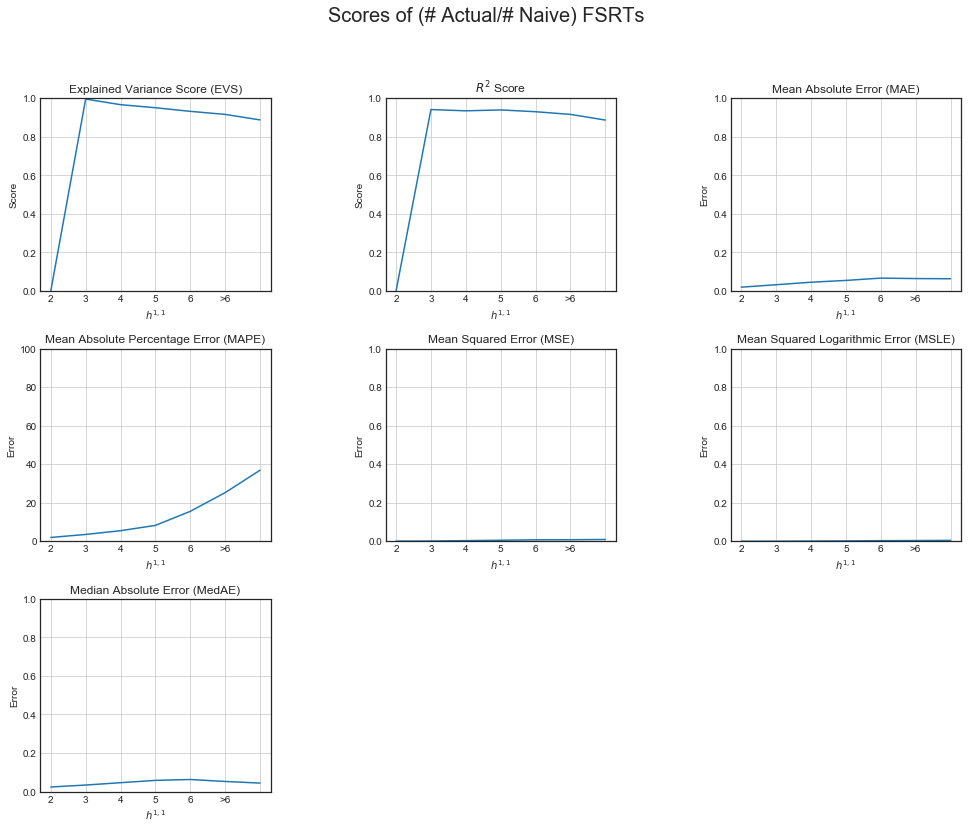

In [179]:
score_attrs = yaml.load(open('score.config', 'r'))

h11_arr = np.arange(1, 6 + 2)
scores = dict([(score_type, np.empty(h11_arr.size)) for score_type in score_attrs.keys()])

for i in range(h11_arr.size):
    if h11_arr[i] <= 6:
        mask = (X_df.H11 == h11_arr[i])
    else:
        mask = (X_df.H11 > 6)
    y_h11 = y_df[mask].values
    pred_y_h11 = pred_y_df[mask].values
    for score_type in score_attrs.keys():
        scores[score_type][i] = avail_metrics[score_type](y_h11, pred_y_h11)

print(path)

with PdfPages(path + '/ratio_scores.pdf') as pdf:
    n_rows = 3
    n_cols = 3
    # fig, ax = plt.subplots(nrows = n_rows, ncols = n_cols)
    fig = plt.figure()#subplots()
    fig.subplots_adjust(wspace = 0.5, hspace = 0.3)
    fig.set_size_inches(1.5 * 11, 1.5 * 8.5)
    fig.suptitle("Scores of (# Actual/# Naive) FSRTs", fontsize = 20)
    scores_items = iter(scores.items())
    for i in range(n_rows):
        for j in range(n_cols):
            if i * n_cols + j >= len(score_attrs):
                break
            key, value = next(scores_items)
            ax = plt.subplot2grid((n_rows, n_cols), (i, j))
            ax.grid()
            ax.set_title(score_attrs[key]['title'])
            ax.set_xlabel("$h^{1,1}$")
            ax.set_xticklabels(np.append(h11_arr[:-1].astype(str), np.array([">6"])))
            ax.set_ylabel(score_attrs[key]['ylabel'])
            ax.set_ylim(score_attrs[key]['ymin'], score_attrs[key]['ymax'])
            ax.plot(h11_arr, value)
    pdf.savefig(fig)
    plt.show()

2018-08-19T00,28,04.27Z


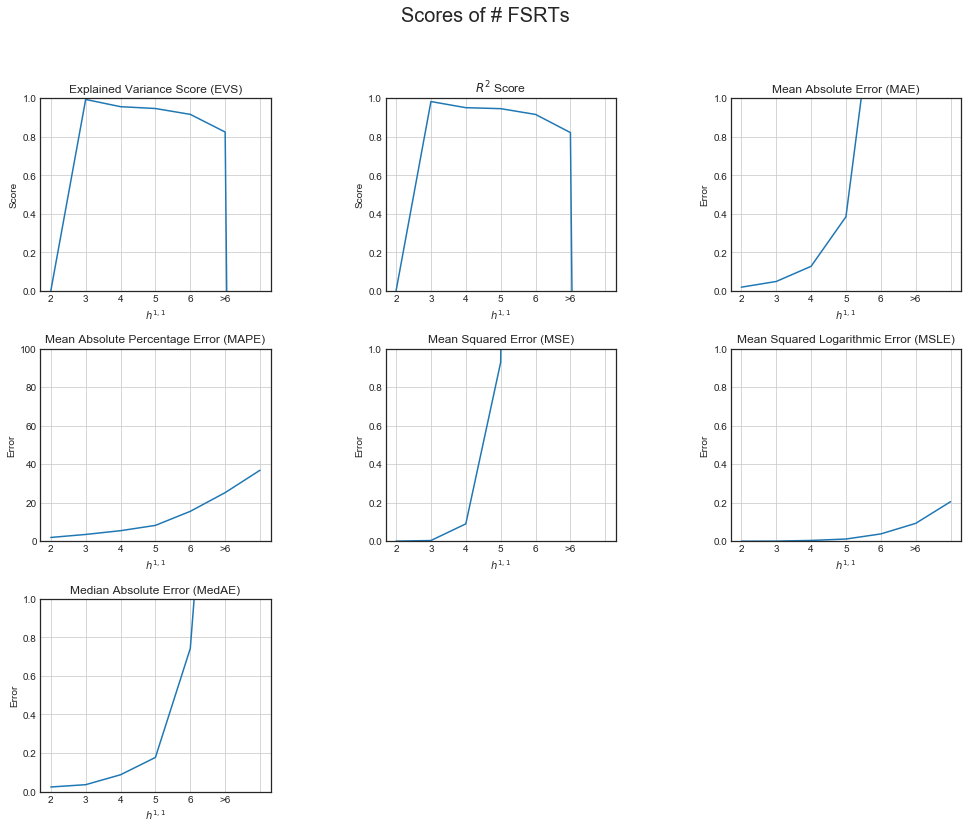

In [180]:
score_attrs = yaml.load(open('score.config', 'r'))

h11_arr = np.arange(1, 6 + 2)
scores = dict([(score_type, np.empty(h11_arr.size)) for score_type in score_attrs.keys()])

for i in range(h11_arr.size):
    if h11_arr[i] <= 6:
        mask = (X_df.H11 == h11_arr[i])
    else:
        mask = (X_df.H11 > 6)
    z_h11 = raw_df.NFSRT[mask].values
    pred_z_h11 = (raw_df.LNNFRTSUM.apply(np.exp) * pred_y_df.NFSRTRAT)[mask].values
    for score_type in score_attrs.keys():
        scores[score_type][i] = avail_metrics[score_type](z_h11, pred_z_h11)

print(path)

with PdfPages(path + '/scores.pdf') as pdf:
    n_rows = 3
    n_cols = 3
    # fig, ax = plt.subplots(nrows = n_rows, ncols = n_cols)
    fig = plt.figure()#subplots()
    fig.subplots_adjust(wspace = 0.5, hspace = 0.3)
    fig.set_size_inches(1.5 * 11, 1.5 * 8.5)
    fig.suptitle("Scores of # FSRTs", fontsize = 20)
    scores_items = iter(scores.items())
    for i in range(n_rows):
        for j in range(n_cols):
            if i * n_cols + j >= len(score_attrs):
                break
            key, value = next(scores_items)
            ax = plt.subplot2grid((n_rows, n_cols), (i, j))
            ax.grid()
            ax.set_title(score_attrs[key]['title'])
            ax.set_xlabel("$h^{1,1}$")
            ax.set_xticklabels(np.append(h11_arr[:-1].astype(str), np.array([">6"])))
            ax.set_ylabel(score_attrs[key]['ylabel'])
            ax.set_ylim(score_attrs[key]['ymin'], score_attrs[key]['ymax'])
            ax.plot(h11_arr, value)
    pdf.savefig(fig)
    plt.show()

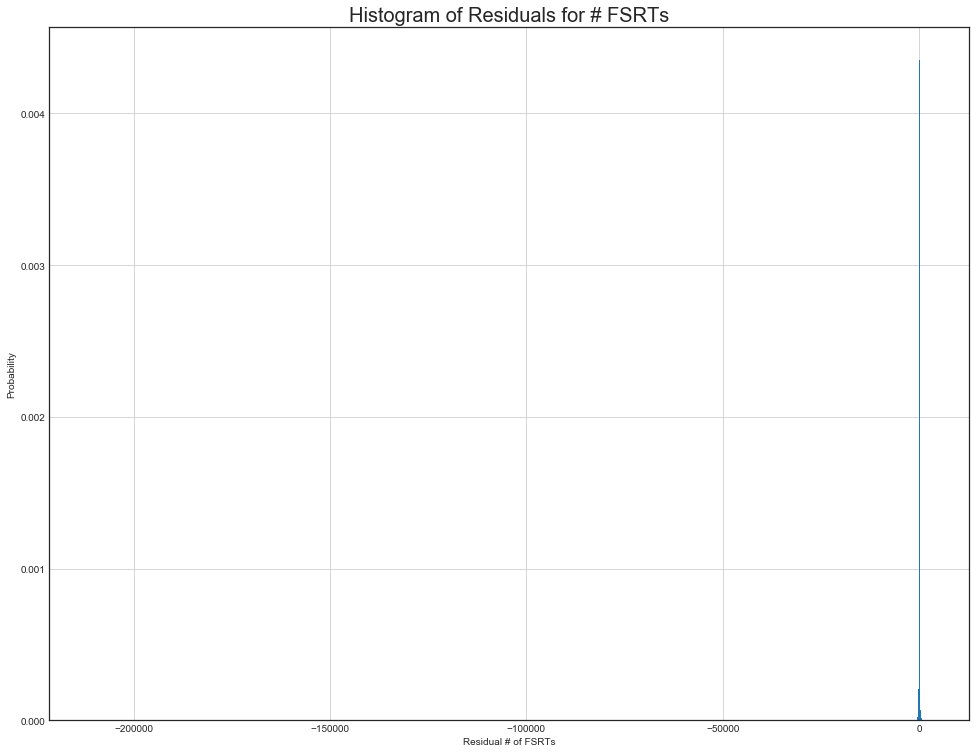

In [181]:
with PdfPages(path + '/hist.pdf') as pdf:
    fig, ax = plt.subplots()
    fig.set_size_inches(1.5 * 11, 1.5 * 8.5)

    diffs = (raw_df.NFSRT - (raw_df.LNNFRTSUM.apply(np.exp) * pred_y_df.NFSRTRAT)).values

    values, bins, patches = ax.hist(diffs, bins = 1000, density = True)
    ax.grid()
    ax.set_title("Histogram of Residuals for # FSRTs", fontsize = 20)
    ax.set_xlabel("Residual # of FSRTs")
    ax.set_ylabel("Probability")

    pdf.savefig(fig)
    plt.show()

In [182]:
# fig, ax = plt.subplots()
# fig.set_size_inches(1.5 * 11, 1.5 * 8.5)

# x_data = raw_df.NFSRT.values
# y_data = (raw_df.LNNFRTSUM.apply(np.exp) * pred_y_df.NFSRTRAT).values

# uniq_labels = list(np.sort(raw_df.H11.unique()).astype(int))
# n_clusters = len(uniq_labels)
# rgb_values = sns.color_palette('hls', n_clusters)
# cmap = ListedColormap(rgb_values.as_hex())
# color_map = dict(zip(uniq_labels, rgb_values))
# colors = raw_df.H11.astype(int)

# scatt = ax.scatter(x_data, y_data, c = colors, cmap = cmap, vmin = 0, vmax = n_clusters)
# ax.set_xlim((x_data.min(), x_data.max()))
# ax.set_ylim((y_data.min(), y_data.max()))
# ax.grid()
# ax.set_title("Actual vs. Predicted Scatter Plot")
# ax.set_xlabel("Actual # of FSRTs")
# ax.set_ylabel("Predicted # of FSRTs")

# fit = np.polyfit(x_data, y_data, deg = 1)
# fit_pos_x = x_data[x_data.size // 2]
# fit_pos_y = (fit[0] * fit_pos_x + fit[1])# + ((1 - 2 * i) * (0.1 * y_data[-1]))
# slope = str("%.2f" % fit[0]) + "x"
# if fit[1] > 0:
#     yintercept = " + " + str("%.2f" % fit[1])
# elif fit[1] < 0:
#     yintercept = " - " + str("%.2f" % -fit[1])
# else:
#     yintercept = ""

# ax.plot(x_data, fit[0] * x_data + fit[1], color = 'black', linestyle = '-', alpha = 1, linewidth = 2, label = "y = " + slope + yintercept)
# # ax.text(fit_pos_x, fit_pos_y, "y = " + slope + yintercept, horizontalalignment = 'left', verticalalignment = 'bottom')
# ax.legend(bbox_to_anchor = (0.85, 1.0, 0.15, 0.1), loc = 'lower left', ncol = 1, mode = "expand", borderaxespad = 0.)

# cbar = fig.colorbar(scatt)
# cbar.set_ticks(np.arange(n_clusters) + 0.5)
# cbar.set_ticklabels(uniq_labels)

# plt.show()

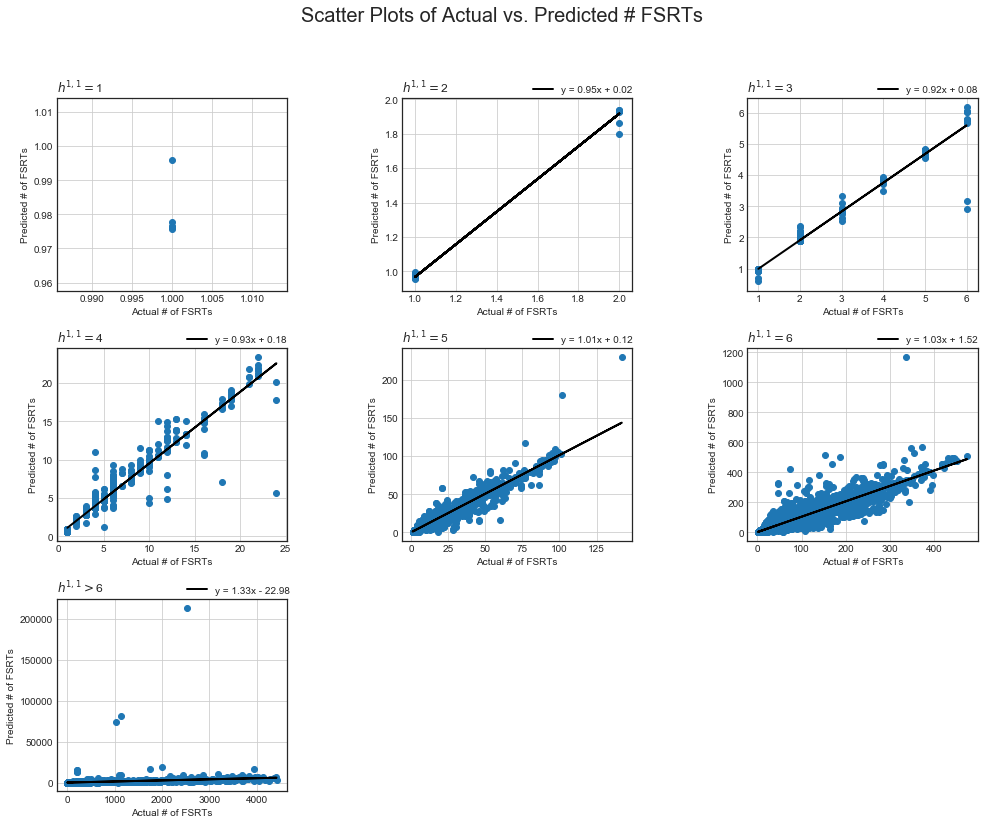

In [183]:
with PdfPages(path + '/scatter.pdf') as pdf:
    n_rows = 3
    n_cols = 3
    # fig, ax = plt.subplots(nrows = n_rows, ncols = n_cols)
    fig = plt.figure()#subplots()
    fig.subplots_adjust(wspace = 0.5, hspace = 0.3)
    fig.set_size_inches(1.5 * 11, 1.5 * 8.5)
    fig.suptitle("Scatter Plots of Actual vs. Predicted # FSRTs", fontsize = 20)

    for i in range(n_rows):
        for j in range(n_cols):
            h11 = i * n_cols + j + 1
            if h11 - 1 > 6:
                break
            mask = (raw_df.H11 == h11)
            if h11 <= 6:
                mask = (raw_df.H11 == h11)
            else:
                mask = (raw_df.H11 > 6)
            x_data = raw_df[mask].NFSRT.values
            y_data = (raw_df[mask].LNNFRTSUM.apply(np.exp) * pred_y_df[mask].NFSRTRAT).values
            
            ax = plt.subplot2grid((n_rows, n_cols), (i, j))

            ax.scatter(x_data, y_data)
    #         ax.set_xlim((x_data.min(), x_data.max()))
    #         ax.set_ylim((y_data.min(), y_data.max()))
            ax.grid()
            if h11 > 6:
                ax.set_title("$h^{1,1} > $" + str(6), loc = 'left')
            else:
                ax.set_title("$h^{1,1} = $" + str(h11), loc = 'left')
            ax.set_xlabel("Actual # of FSRTs")
            ax.set_ylabel("Predicted # of FSRTs")

            if np.unique(x_data).size > 1:
                fit = np.polyfit(x_data, y_data, deg = 1)
                fit_pos_x = x_data[x_data.size // 2]
                fit_pos_y = (fit[0] * fit_pos_x + fit[1])# + ((1 - 2 * i) * (0.1 * y_data[-1]))
                slope = str("%.2f" % fit[0]) + "x"
                if fit[1] > 0:
                    yintercept = " + " + str("%.2f" % fit[1])
                elif fit[1] < 0:
                    yintercept = " - " + str("%.2f" % -fit[1])
                else:
                    yintercept = ""

                ax.plot(x_data, fit[0] * x_data + fit[1], color = 'black', linestyle = '-', alpha = 1, linewidth = 2, label = "y = " + slope + yintercept)
                ax.legend(bbox_to_anchor = (0.55, 1.0, 0.45, 0.1), loc = 'lower left', ncol = 1, mode = "expand", borderaxespad = 0.)

    pdf.savefig(fig)
    plt.show()